# Demo of the Collage and SlicePicker classes

Much of the data in neuroimaging is 3D, be it a simple anatomical scan or a volumetric segmentation or PET metabolic uptake image or a reference atlas. And they are large - hundreds of slices (cross-sections) that can't be easily displayed with native visualization tools. There are many viewers available to visualize either 1 slice from all planes (the most common), or completely unwrap and dump them into large collage (with some advanced use). However, they are neither customizable nor programmatically accessible in your cool new application or a specific need. 

Developing these classes is an attempt to make it easy to generate visualizations that solve the non-trivial visualization needs of 3D/4D neuroimaging data.

At the moment, `mrivis` provides two sets of functionalities:
- set of methods to compare the spatial alignment of two 3d images (checkerboard, color mix, edge overlay etc)
- set of classes (`SlicePicker` and `Collage`) to enable even more customizable visualizations with few commands

This notebook illustrates the use of the latter classes: `Collage` and `SlicePicker`, which are designed to make the programmatic display of 3D images easy and their customization easier!

Let's get started with some necessary imports

In [4]:
!pip install numpy matplotlib nibabel mrivis

/bin/sh: 1: source: not found


In [1]:
from os.path import join as pjoin, abspath, realpath, basename, dirname, exists as pexists
from mrivis.utils import read_image, scale_0to1
from matplotlib import pyplot as plt

ModuleNotFoundError: ignored

If you are going to try this at home, change the below to load two MRIs

In [0]:

# CHANGE THE FOLLOWING so path_one and path_two will be paths to two MRIs
base_dir = '/Users/Reddy/dev/mrivis/example_datasets'
path_one = pjoin(base_dir, '3569_bl_PPMI.nii')
path_two = pjoin(base_dir, '4086_bl_PPMI.nii')


img_one = read_image(path_one, None)
img_two = read_image(path_two, None)

scaled_img_one = scale_0to1(img_one) # scaling to avoid problems with narrow distributions
scaled_img_two = scale_0to1(img_two)

/Users/Reddy/dev/mrivis/mrivis/utils.py:133: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(img.dtype, np.float):


# SlicePicker

SlicePicker is a class to help you traverse through the 3D volumes easily, giving you the choice of how you pick slices, which planes and how many! For example, you could select 10 slices from each plane, linearly sampled between first and last slice, or pick them at quartiles from only sagittal view, or employ a sophisticated criterion whether a particular slice is incldued or not based on the data in that slice (do a specific set of labels or image properties you are interested in exist? etc). This class also makes it easy to synchronize the slice selection across multiple volumes. This class that powers the `Collage` class.

Let's see some examples:

In [0]:
# importing the shiny new class
from mrivis import SlicePicker

Using this class requires knowning which image you want pick slices from. So let's initiate one with just defaults.

In [0]:
sp = SlicePicker(scaled_img_one) # with just defaults

You might want to know what this class is and how this works. Let's look at what it is:

In [0]:
sp

10 slices in dim 0 : [  0  18  35  53  70  88 106 123 141 158]
10 slices in dim 1 : [  0  24  48  72  96 120 143 167 191 215]
10 slices in dim 2 : [  0  26  51  76 102 128 153 178 204 230]

So, this class picked 10 slices (non-empty) from each of the views, and is showing you the exact slice numbers. That's cool - how do I get the slices for those indices, you say? Easy with `SlicePicker.get_slices()` which spits out each slice in succession!

PS: You might not be able to see the animation in the jupyter notebook.

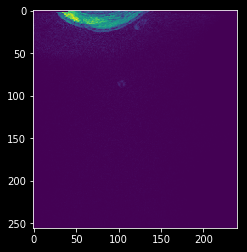

In [0]:
fig, ax = plt.subplots(1, 1, squeeze=True)
from time import sleep
for sl_data in sp.get_slices():
    ax.cla()
    ax.imshow(sl_data)
    sleep(0.1)
    plt.pause(0.001)

Let's say you are interested in selecting only dimesnion 0, and increasing the number of slices to 35. It is easy to do with:

In [0]:
sp_sagittal = SlicePicker(scaled_img_one, view_set=(0, ), num_slices=35)
sp_sagittal

35 slices in dim 0 : [  0   5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85
  91  96 101 106 111 116 121 126 131 136 141 146 151 156 161 166 171]

Or 15 slices in dimension 1 and 25 in dimension 2?

In [0]:
sp2 = SlicePicker(scaled_img_one, view_set=(1, 2), num_slices=(15, 25))
sp2

15 slices in dim 1 : [  0  16  32  48  64  80  96 112 127 143 159 175 191 207 223]
25 slices in dim 2 : [  0  10  20  31  41  51  61  71  82  92 102 112 122 133 143 153 163 173
 184 194 204 214 224 235 245]

That's cool. Now, let's say you are interested in customizing the selection density e.g. increasing the density of slices in the middle - how can you do that? Just pass in a sampler, indicating the percentage points. For example:

In [0]:
in_sampler = (5, 30, 35, 40, 45, 50, 55, 60, 65, 70, 95)
# that is 9 slices between 30-70% and one slice each at both tails
middle_sp = SlicePicker(scaled_img_one, sampler=in_sampler)

You can check that the selection actually reflects that:

In [0]:
middle_sp

11 slices in dim 0 : [  9  53  62  70  79  88  97 106 114 123 167]
11 slices in dim 1 : [ 12  72  84  96 108 120 131 143 155 167 227]
11 slices in dim 2 : [ 13  76  89 102 115 128 140 153 166 178 242]

For your unique application, you might want to apply a sophisticated criterion whether a particular slice is incldued or not based on the data in that slice - you might require certain minimum amount of density of non-zero voxels, or require specific set of labels or image properties you are interested in exist? That can easily be achieved by passing in a function (callable). This function must take in a slice (2d matrix/image) and return a boolean decision whether to select it or not.

For example, a function to ensure a min amount of density could look like this:

In [0]:
def density_over(img2d, min_density = 0.9):
    """Checks if the non-zero pixel density in input image is over a given percetnage."""

    return (np.count_nonzero(img2d.flatten())/img2d.size)>=min_density

You can pass it in like the previous sampler:

In [0]:
fancy_sp = SlicePicker(scaled_img_one, sampler=density_over)
fancy_sp

10 slices in dim 0 : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
10 slices in dim 1 : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
10 slices in dim 2 : [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

Note, the sampler could be sophisticated as you want - check for the presence of certain ROI set or even a complicated property check on the data within the ROI set.

Now, suppose say, you want to see the same slice from multiple images (registered to each other voxelwise), and it's easy:

In [0]:
# lets have two subplots
fig, ax = plt.subplots(2, 1, squeeze=True)

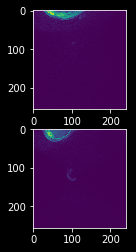

In [0]:
# you just need to pass in all the 
for s1, s2 in sp.get_slices_multi([img_one, img_two]):
    ax[0].imshow(s1)
    ax[1].imshow(s2)    
    sleep(0.1)
    plt.pause(0.001)
#
# PS: You might not be able to see the animation in the jupyter notebook.

Complete info about this class can be obtained with `help(SlicePicker)`

# Collage

For typical scenarios, you might want a simple and quick way to bring up a collage, at various stages of your algorithm or app! That's what `Collage` is for.

In [0]:
# importing the shiny new class
from mrivis import Collage
# creating a collage with default layout
collage = Collage()

In [0]:
collage

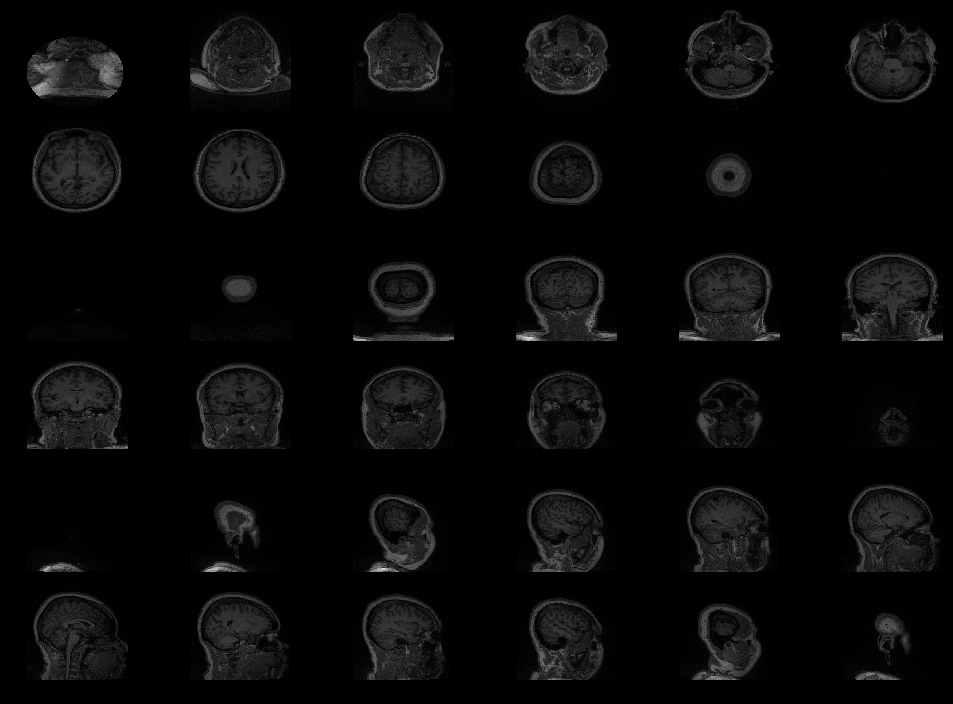

In [0]:
# displaying an MR image with default layout is as simple as attaching it
collage.attach(scaled_img_one)
plt.show(collage.fig) 

And, that's it! You've a full collage giving a full overview! 

That's not all. Neuroimaging research demands diverse visualizations, and not all visualizations present you with the same `SNR` for all use cases. So you might want to control which planes/views you want to see, and how many slices for the views! They are as simple as passing in the wishlist to the collage class! 

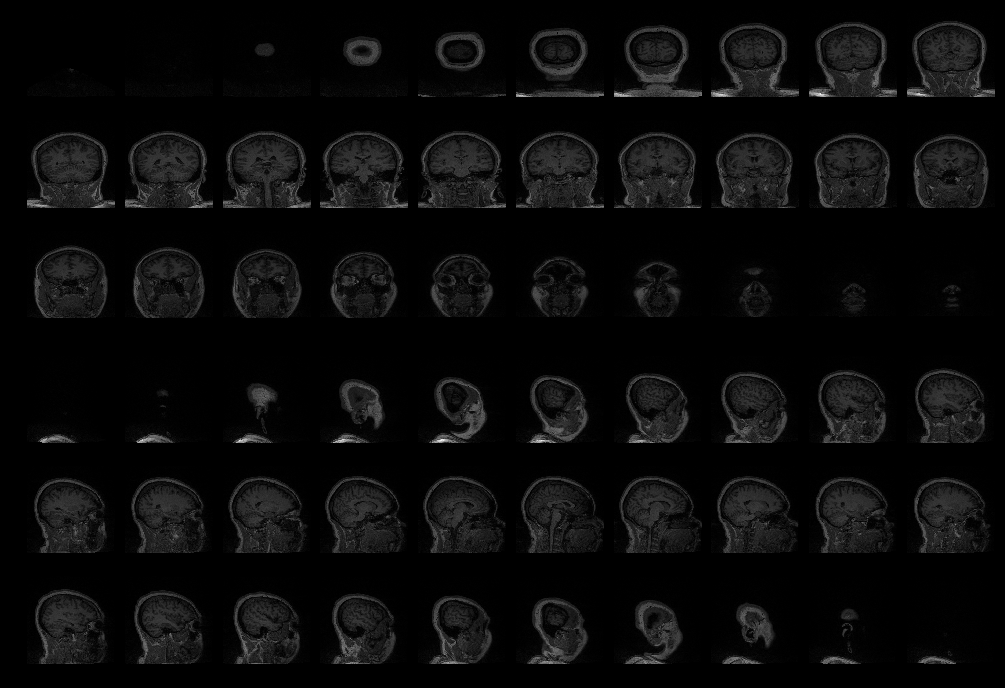

In [0]:
c2 = Collage(view_set=(0,1), num_slices=30, num_rows=3)
c2.attach(scaled_img_one)
plt.show()

Now you only see coronal and sagittal views, with 30 slices in each views, spread in 3 rows/views. Collage offers all the flexibility of `SlicePicker` without you having to assemble them yourself. Also, you can directly attach an image during creation if you want to!

Coming: vary the number of slices per each view (this is implemented, needs to be tested more)

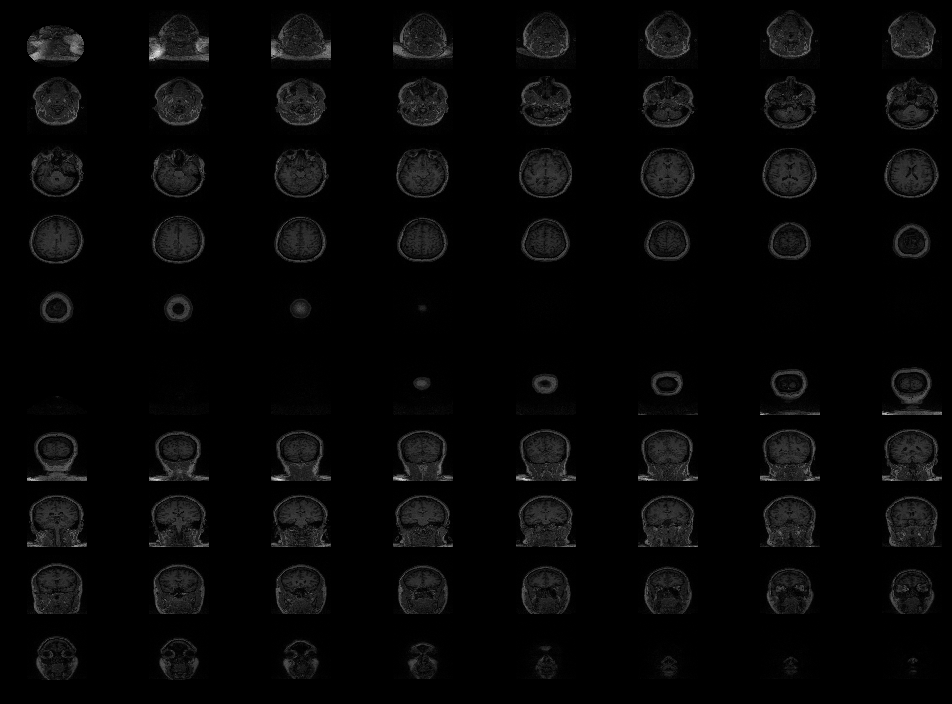

In [0]:
c2 = Collage(view_set=(1,2), num_slices= 40, num_rows=5, attach_image=scaled_img_one)
plt.show()

when you are making custom visuzalition, you might want to combine this with another visualization alongside. That requires you to control the rectangular area of the figure you would like to restrict the collage to. Easy!

Let's show 9 slices of axial view in the top right corner! 

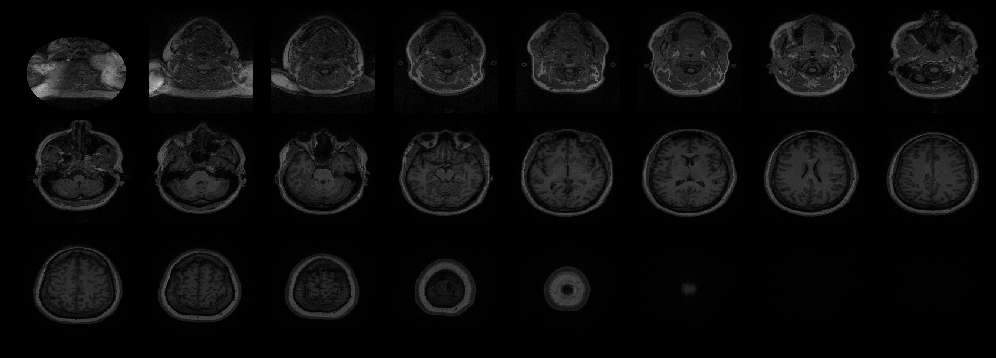

In [0]:
c2 = Collage(view_set=(2, ), num_slices= 24, num_rows=3, bounding_rect=(0.5, 0.5, 0.98, 0.98))
c2.attach(scaled_img_one)
plt.show()

There are other options available to this class (such as display parameters e.g. colormap, etc), which you can explore with `help()`

Thanks for checking it out. I apprecite and welcome your [**feedback**](github.com/raamana/mrivis)